In [ ]:
import numpy as np
import random
import gymnasium as gym
from collections import deque
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# ===========================================================
#                     SUMTREE (PER)
# ===========================================================
class SumTree:
    def __init__(self, capacity):
        self.capacity = capacity
        self.tree = np.zeros(2 * capacity - 1)
        self.data = np.zeros(capacity, dtype=object)
        self.write = 0

    def add(self, p, data):
        idx = self.write + self.capacity - 1
        self.data[self.write] = data
        self.update(idx, p)

        self.write += 1
        if self.write >= self.capacity:
            self.write = 0

    def update(self, idx, p):
        change = p - self.tree[idx]
        self.tree[idx] = p

        while idx != 0:
            idx = (idx - 1) // 2
            self.tree[idx] += change

    def get_leaf(self, value):
        parent = 0

        while True:
            left = 2 * parent + 1
            right = left + 1

            if left >= len(self.tree):
                leaf = parent
                break
            else:
                if value <= self.tree[left]:
                    parent = left
                else:
                   value -= self.tree[left]
                    parent = right

        data_idx = leaf - self.capacity + 1
        return leaf, self.tree[leaf], self.data[data_idx]

    @property
    def total_p(self):
        return self.tree[0] 
        

In [ ]:
# ===========================================================
#                     PER BUFFER
# ===========================================================
class PERBuffer:
    def __init__(self, capacity, alpha=0.6):
        self.tree = SumTree(capacity)
        self.alpha = alpha
        self.epsilon = 1e-4
        self.capacity = capacity

    def add(self, error, sample):
        p = (np.abs(error) + self.epsilon) ** self.alpha
        self.tree.add(p, sample)

    def sample(self, n):
        batch = []
        idxs = []
        segment = self.tree.total_p / n
        for i in range(n):
            a = segment * i
            b = segment * (i + 1)
            s = random.uniform(a, b)
            idx, p, data = self.tree.get_leaf(s)
            batch.append((idx, p, data))
            idxs.append(idx)

        priorities = np.array([p for (_, p, _) in batch])
        samples = [d for (_, _, d) in batch]

        return idxs, priorities, samples

    def update(self, idx, error):
        p = (np.abs(error) + self.epsilon) ** self.alpha
        self.tree.update(idx, p)

In [ ]:
# ===========================================================
#               DUELING Q-NETWORK
# ===========================================================
class DuelingQNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()

        self.feature = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
        )

        self.value_stream = nn.Sequential(
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )
        self.adv_stream = nn.Sequential(
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, action_dim)
        )

    def forward(self, x):
        if x.dim() == 1:
            x = x.unsqueeze(0)

        f = self.feature(x)
        value = self.value_stream(f)
        adv = self.adv_stream(f)
        adv_mean = adv.mean(dim=1, keepdim=True)
        q = value + adv - adv_mean
        return q


In [ ]:
# ===========================================================
#               AGENT (PER + DDQN + DUELING)
# ===========================================================
class Agent:
    def __init__(self, state_dim, action_dim):
        self.action_dim = action_dim

        self.policy_net = DuelingQNetwork(state_dim, action_dim).to(device)
        self.target_net = DuelingQNetwork(state_dim, action_dim).to(device)
        self.target_net.load_state_dict(self.policy_net.state_dict())

        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=1e-4)
        self.loss_fn = nn.SmoothL1Loss(reduction="none")

        self.buffer = PERBuffer(100000)
        self.gamma = 0.99

        self.steps = 0
        def act(self, state, epsilon):
        if random.random() < epsilon:
            return random.randint(0, self.action_dim - 1)
        with torch.no_grad():
            s = torch.FloatTensor(state).to(device)
            q = self.policy_net(s)
            return torch.argmax(q).item()

    def store(self, state, action, reward, next_state, done):
        sample = (state, action, reward, next_state, done)
        self.buffer.add(1.0, sample)

    def train(self, batch_size):
        idxs, priorities, samples = self.buffer.sample(batch_size)

        states, actions, rewards, next_states, dones = zip(*samples)

        states = torch.FloatTensor(states).to(device)
        actions = torch.LongTensor(actions).to(device)
        rewards = torch.FloatTensor(rewards).to(device)
        next_states = torch.FloatTensor(next_states).to(device)
        dones = torch.FloatTensor(dones).to(device)

        q_values = self.policy_net(states).gather(1, actions.unsqueeze(1)).squeeze()

        with torch.no_grad():
            next_actions = self.policy_net(next_states).argmax(1)
            next_q = self.target_net(next_states).gather(1, next_actions.unsqueeze(1)).squeeze()
            targets = rewards + self.gamma * next_q * (1 - dones)

        errors = (targets - q_values).detach().cpu().numpy()

        for i, idx in enumerate(idxs):
            self.buffer.update(idx, errors[i])

        loss = (self.loss_fn(q_values, targets)).mean()

        self.optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(self.policy_net.parameters(), 10)
        self.optimizer.step()

        return loss.item()
        

Ep 50/500, Avg Reward(50): -142.2, Eps: 0.774
Ep 100/500, Avg Reward(50): -59.2, Eps: 0.603
Ep 150/500, Avg Reward(50): -52.8, Eps: 0.469
Ep 200/500, Avg Reward(50): -21.1, Eps: 0.365
Ep 250/500, Avg Reward(50): 58.0, Eps: 0.284
Ep 300/500, Avg Reward(50): 94.5, Eps: 0.221
Ep 350/500, Avg Reward(50): 135.0, Eps: 0.172
Ep 400/500, Avg Reward(50): 117.1, Eps: 0.134
Ep 450/500, Avg Reward(50): 185.4, Eps: 0.104


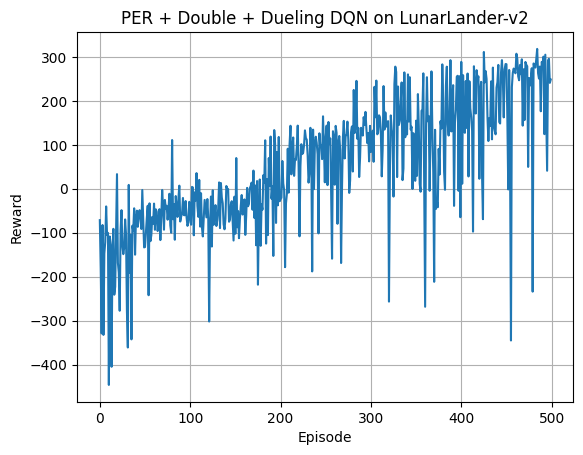

In [20]:

# ===========================================================
#                      TRAINING
# ===========================================================
env = gym.make("LunarLander-v2")

state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

agent = Agent(state_dim, action_dim)

num_episodes = 500
batch_size = 64

epsilon = 1.0
epsilon_decay = 0.995
epsilon_min = 0.05

target_update = 500

rewards_history = []

for ep in range(num_episodes):
    state = env.reset()[0]
    total_reward = 0
    done = False

    while not done:
        agent.steps += 1

        action = agent.act(state, epsilon)
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        agent.store(state, action, reward, next_state, done)

        state = next_state
        total_reward += reward

        if agent.buffer.tree.write > batch_size:
            agent.train(batch_size)
            agent.train(batch_size)

        if agent.steps % target_update == 0:
            agent.target_net.load_state_dict(agent.policy_net.state_dict())

    epsilon = max(epsilon_min, epsilon * epsilon_decay)
    rewards_history.append(total_reward)

    if ep % 50 == 0 and ep > 0:
        avg = np.mean(rewards_history[-50:])
        print(f"Ep {ep}/{num_episodes}, Avg Reward(50): {avg:.1f}, Eps: {epsilon:.3f}")


env.close()

plt.plot(rewards_history)
plt.title("PER + Double + Dueling DQN on LunarLander-v2")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.grid()
plt.show()


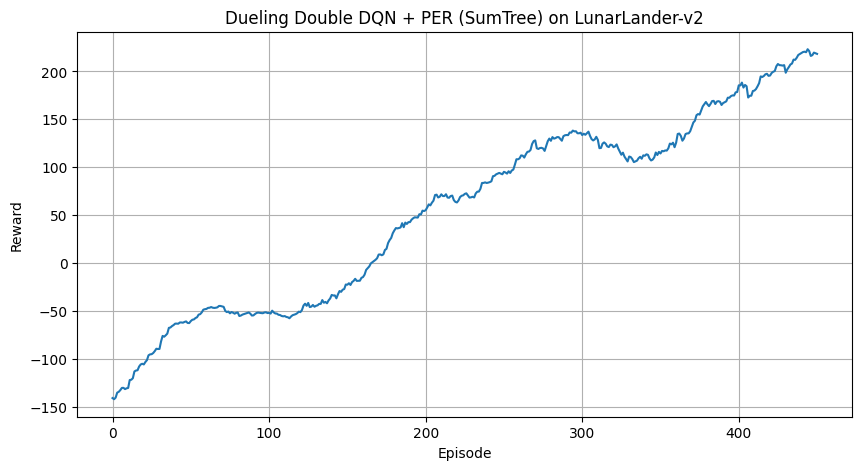

In [23]:
plt.figure(figsize=(10,5))
plt.plot(np.convolve(rewards_history, np.ones(50)/50, mode='valid'))
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Dueling Double DQN + PER (SumTree) on LunarLander-v2')
plt.grid(True)
plt.show() 